In [101]:
library(DBI)
library(RPostgres)
library(sf)
library(ggplot2)
library(dplyr)
library(readxl)
library(readr)
library(lubridate)
library(repr)
library(scales)
library(stringr)
library(gghdx)
library(httr)
library(tidyr)

options(repr.plot.width=20, repr.plot.height=10)
pg_pw_prod = Sys.getenv("AZURE_DB_PW_PROD")
gghdx()

# env keys set based creds stored in bitwarden
con <- DBI::dbConnect(
    drv = RPostgres::Postgres(),
    user = "chdadmin",
    host = "chd-rasterstats-prod.postgres.database.azure.com",
    password = pg_pw_prod,
    port = 5432,
    dbname = "postgres"
  )

In [117]:
font_sizing <- theme(
    plot.title = element_text(size = 50),
    plot.subtitle = element_text(size = 40),
    legend.title = element_text(size = 50), 
    legend.text = element_text(size = 50), 
    axis.text.x = element_text(size = 60),
    axis.text.y = element_text(size = 60),
    strip.text = element_text(size = 30),
    axis.title = element_text(size = 60),
    plot.caption = element_text(size = 30)
  )


## 0. Review EM-DAT and CERF data

In [67]:
df_emdat <- read_excel(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "public_emdat_custom_request.xlsx"
    ),
    sheet = "EM-DAT Data"
) %>%
    filter(`Disaster Type` == "Drought") %>%
    select(`No. Affected`, `Total Affected`, `Location`, `Start Year`, `Start Month`, `End Year`, `End Month`) %>%
    arrange(desc(`Start Year`))

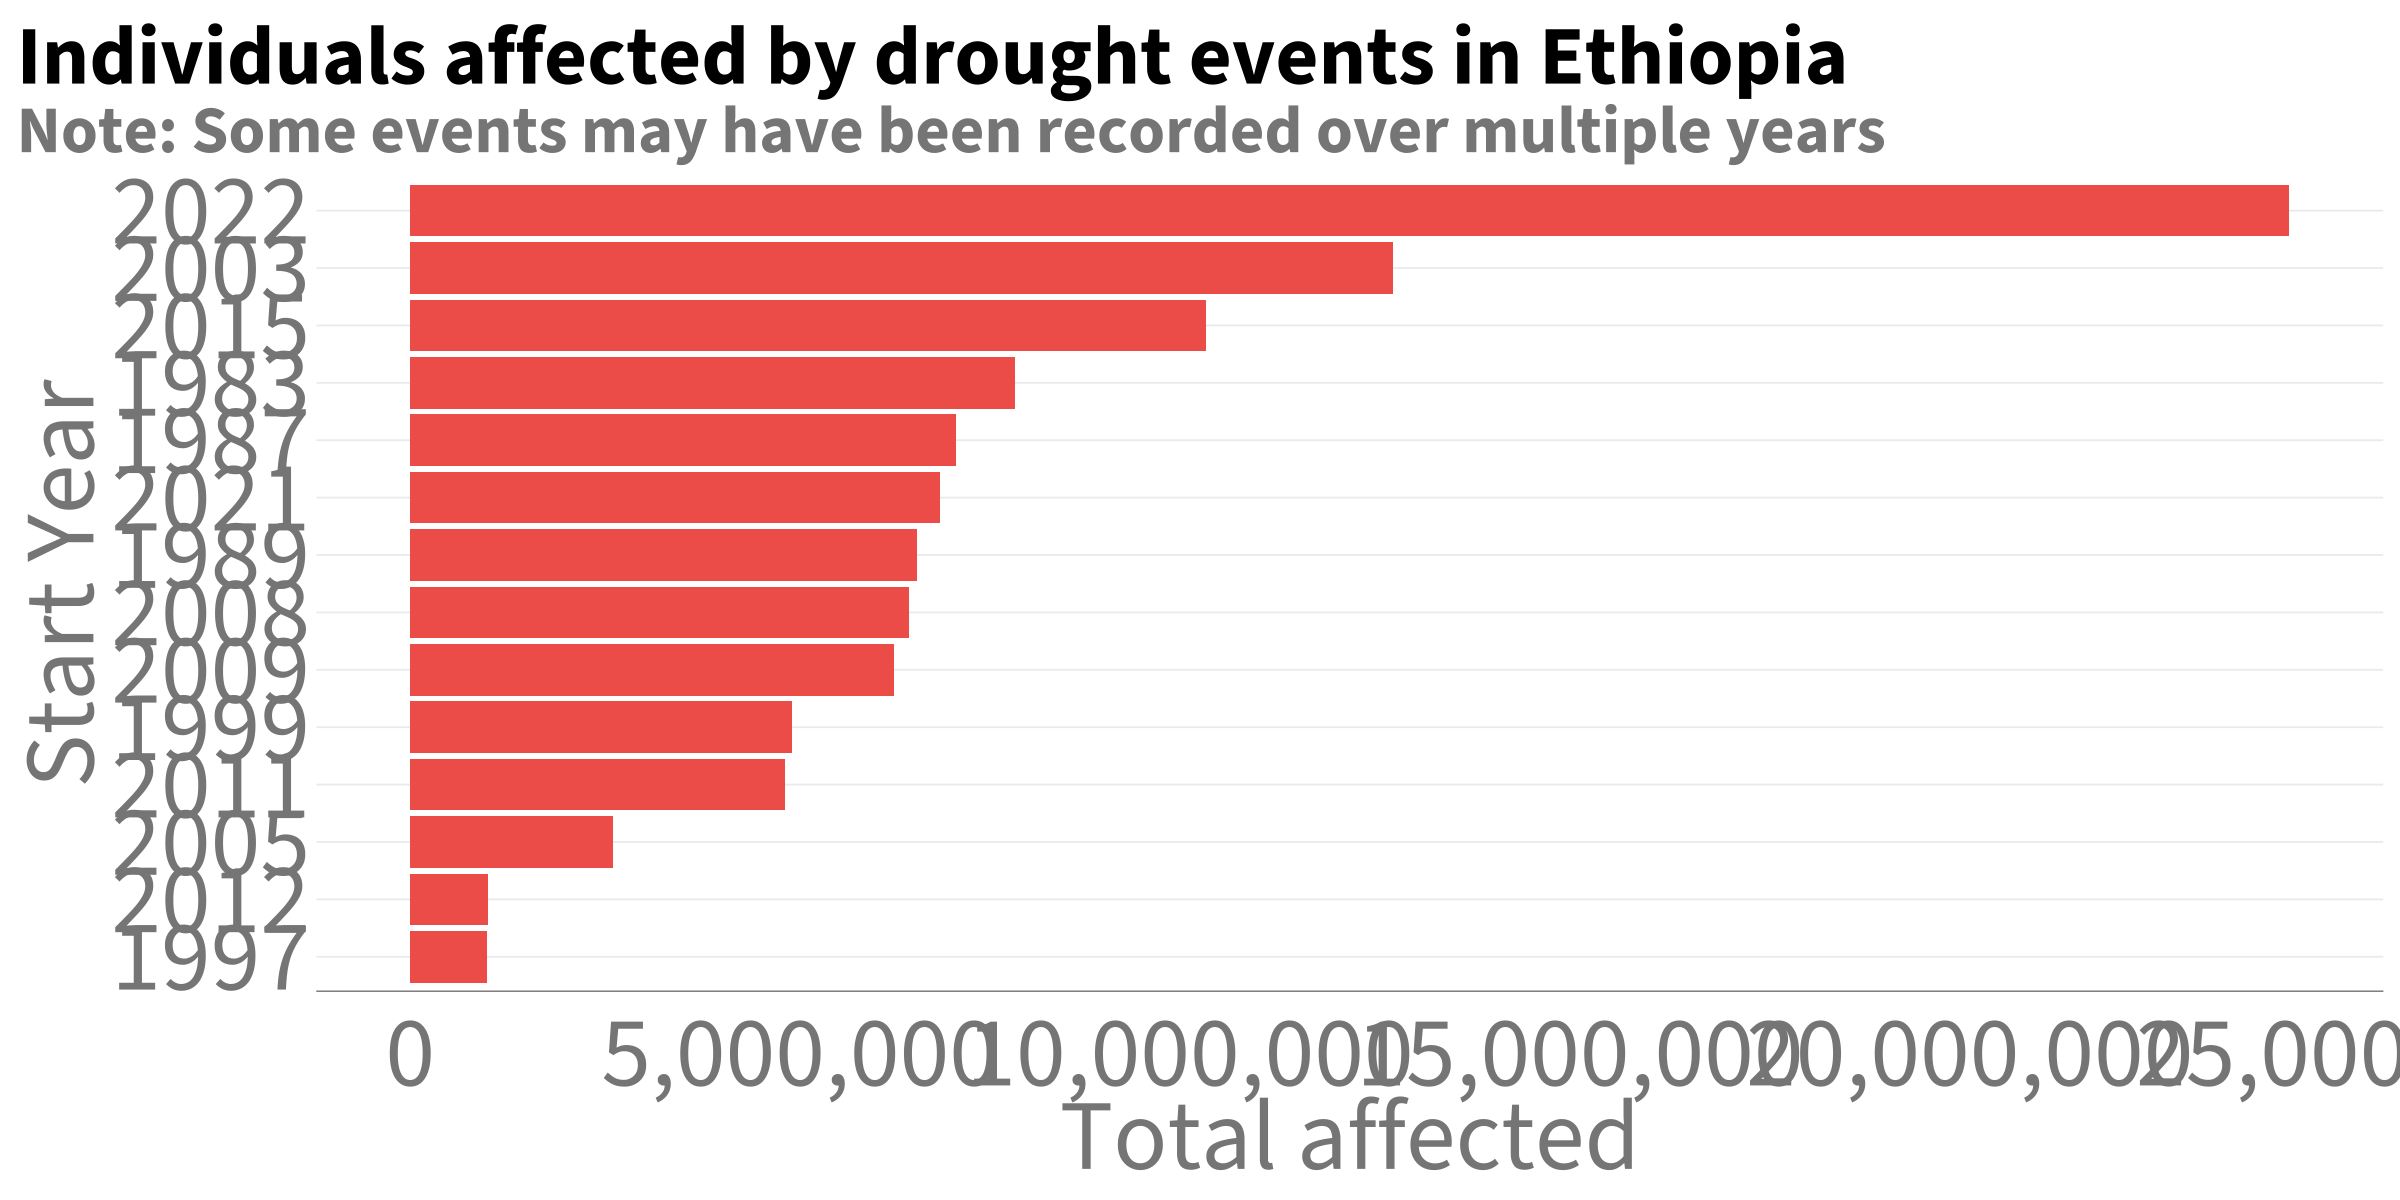

In [118]:
df_emdat_summary <- df_emdat %>%
    group_by(`Start Year`) %>%
    rename(year = `Start Year`) %>%
    summarise(total_affected = sum(`Total Affected`)) %>%
    drop_na() %>%
    arrange(total_affected)

df_emdat_summary$year <- factor(df_emdat_summary$year, levels = df_emdat_summary$year)

ggplot(df_emdat_summary, aes(x=year, y=total_affected)) + 
    geom_bar(fill = hdx_hex("tomato-hdx"), stat="identity") +
    scale_y_continuous(labels = comma_format(big.mark = ",")) +
    labs(
        x="Start Year", 
        y="Total affected", 
        title="Individuals affected by drought events in Ethiopia",
        subtitle="Note: Some events may have been recorded over multiple years") +
    coord_flip() + 
    font_sizing

ggsave("emdat.png", width = 20, height = 30, units = "cm")

In [4]:
df_cerf <- read_csv(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "cerf-allocations.csv"
    ),
    show_col_types=FALSE
) %>%
    filter(countryCode == "ETH" & emergencyTypeName == "Drought") %>%
    select("agencyName", "countryCode", "projectTitle", "year", "totalAmountApproved", "dateUSGSignature") %>%
    arrange(desc("year"))

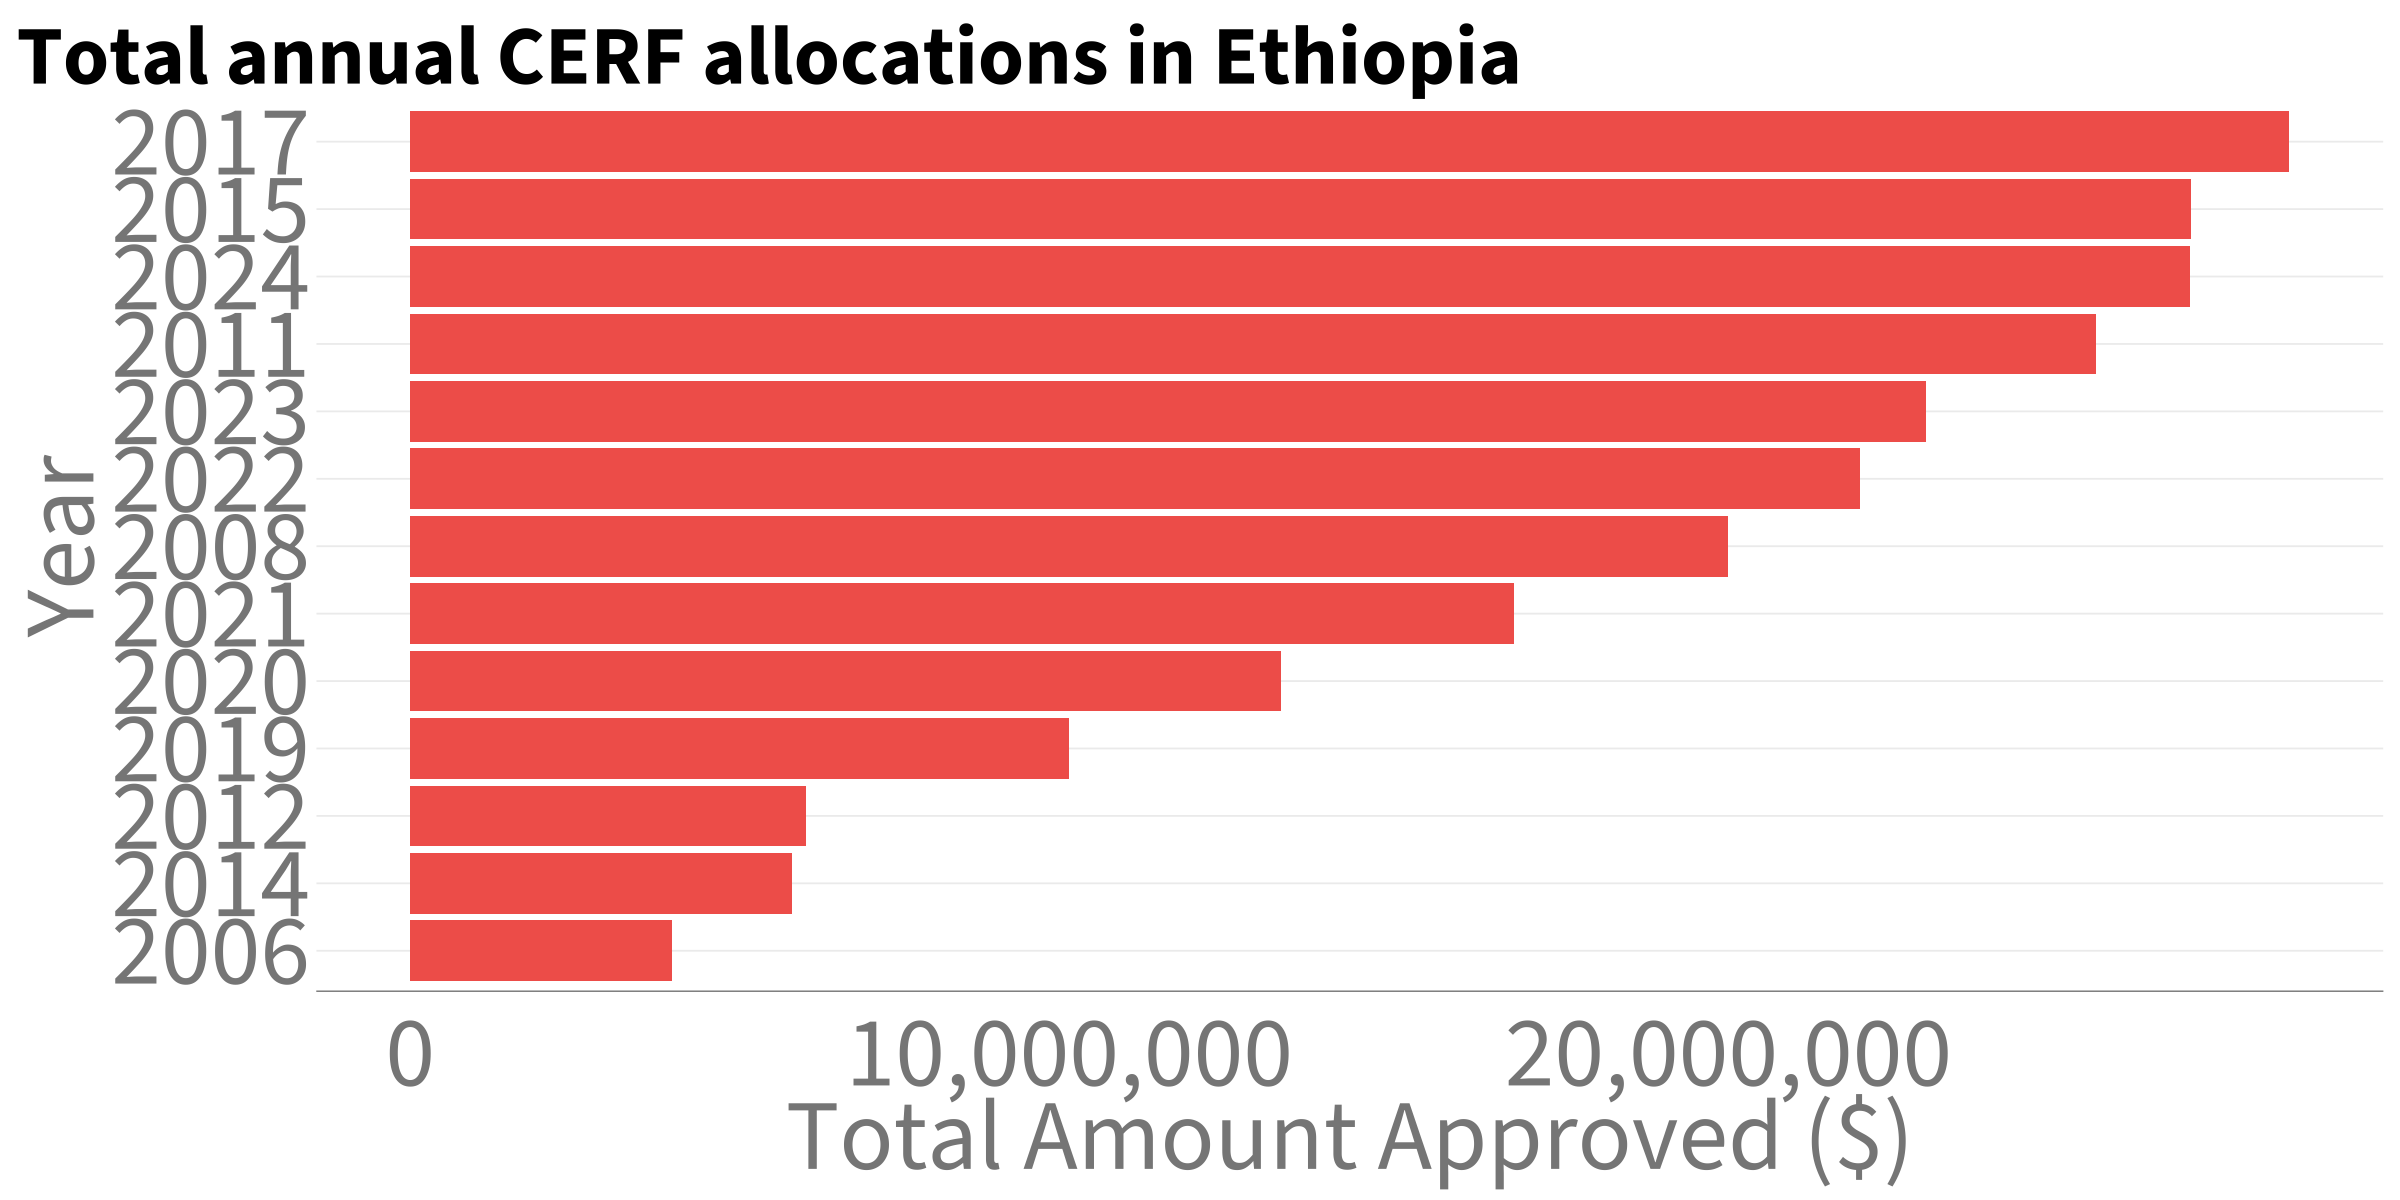

In [119]:
df_cerf_summary <- df_cerf %>%
    group_by(year) %>%
    summarise(total_approved = sum(totalAmountApproved)) %>%
    arrange(total_approved)

df_cerf_summary$year <- factor(df_cerf_summary$year, levels = df_cerf_summary$year)

ggplot(df_cerf_summary, aes(x=year, y=total_approved)) + 
    geom_bar(fill = hdx_hex("tomato-hdx"), stat="identity") +
    scale_y_continuous(labels = comma_format(big.mark = ",")) +
    labs(x="Year", y="Total Amount Approved ($)", title="Total annual CERF allocations in Ethiopia") +
    coord_flip() + 
    font_sizing

ggsave("cerf.png", width = 20, height = 30, units = "cm")

## 1. Cleaning 2024 PiN data

We need go get the total 2024 PiN values across all zones (ADM2) in Ethiopia, then subset by our best estimate of zones that experience the MAM season.

In [5]:
# Get the admin bounds
eth_adm2 <- st_read(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "raw", "eth", "cod_ab", "Admin_2024.gdb.zip"), 
    layer = "eth_admbnda_adm2_csa_bofedb_2024") %>%
    filter(!(admin2Pcode %in% list("ET0000", "ET1000")))

Reading layer `eth_admbnda_adm2_csa_bofedb_2024' from data source 
  `/Users/hannahker/Library/CloudStorage/GoogleDrive-hannah.ker@humdata.org/Shared drives/Data Science/CERF Anticipatory Action/General - All AA projects/Data/public/raw/eth/cod_ab/Admin_2024.gdb.zip' 
  using driver `OpenFileGDB'
Simple feature collection with 103 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 32.9918 ymin: 3.40667 xmax: 47.98824 ymax: 14.84548
Geodetic CRS:  WGS 84


In [6]:
# Get the PiN data and join with the geodataframe
df_pin <- read_excel(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "ethiopia-2024-humanitairan-needs-overview_hxl.xlsx"
    ),
    sheet = "Overall PIN"
)  %>% 
    slice(-1) %>% 
    mutate(`Overall PIN` = as.numeric(`Overall PIN`)) %>%
    group_by(admin2Pcode) %>%
    summarise(TotalPin = sum(`Overall PIN`, na.rm = TRUE)) %>%
    select("admin2Pcode", "TotalPin")

gdf_adm2 <- eth_adm2 %>%
    merge(df_pin, by="admin2Pcode", all.x=TRUE)

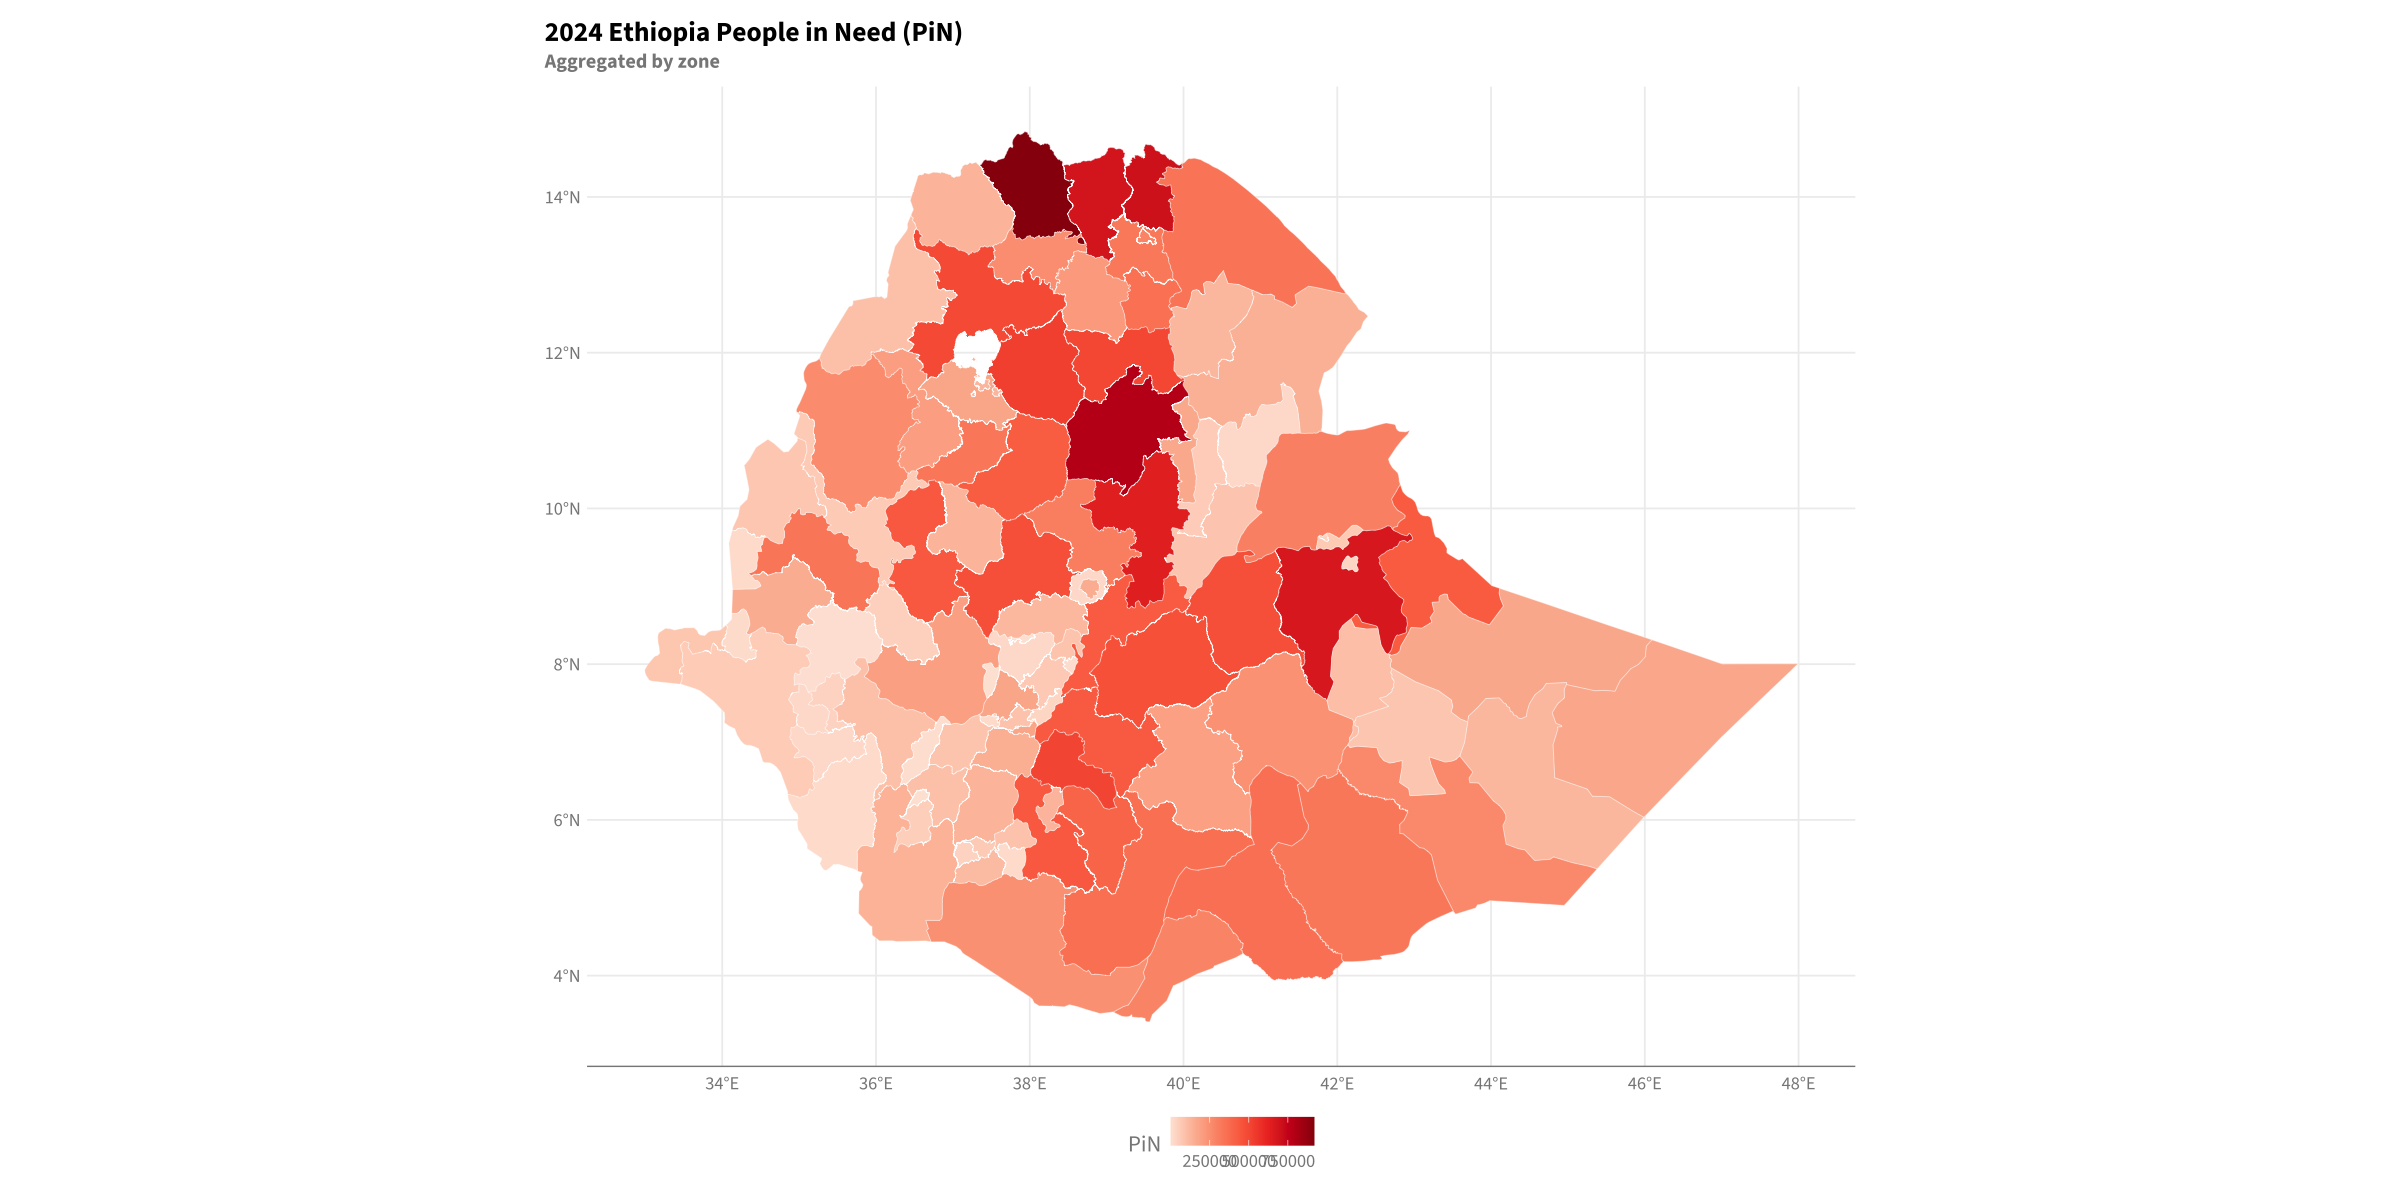

In [7]:
ggplot(data = gdf_adm2) +
  geom_sf(aes(fill = TotalPin), linewidth=0.1, color="white") +
  scale_fill_distiller(palette = "Reds", direction = 1) + 
  # font_sizing +
  labs(title = "2024 Ethiopia People in Need (PiN)",
       subtitle = "Aggregated by zone", 
       fill = "PiN")

In [8]:
# MAM and OND zones defined by FEWSNET
df_mam_ond <- read_csv(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "mam_ond_zones_fewsnet.csv"
    ),
    show_col_types=FALSE
)

# Also hard-code in some zones 
ond_zones <- list(
    "ET0508",
    "ET0806",
    "ET0808",
    "ET0411",
    "ET0412",
    "ET0810",
    "ET0511",
    "ET0807",
    "ET0507",
    "ET0421",
    "ET0410",
    "ET0504",
    "ET0502",
    "ET0802",
    "ET0414",
    "ET0503",
    "ET0809",
    "ET0505",
    "ET0509",
    "ET0510",
    "ET0506",
    "ET0812",
    "ET0415",
    "ET0422",
    "ET0408",
    "ET0417",
    "ET1600",
    "ET0811"
)

# Filter the gdf to only include the admin areas that experience ond/mam seasons
gdf_ond_mam <- gdf_adm2 %>%
    filter(
        admin2Pcode %in% df_mam_ond$admin2Pcode |
        admin2Pcode %in% ond_zones
    )

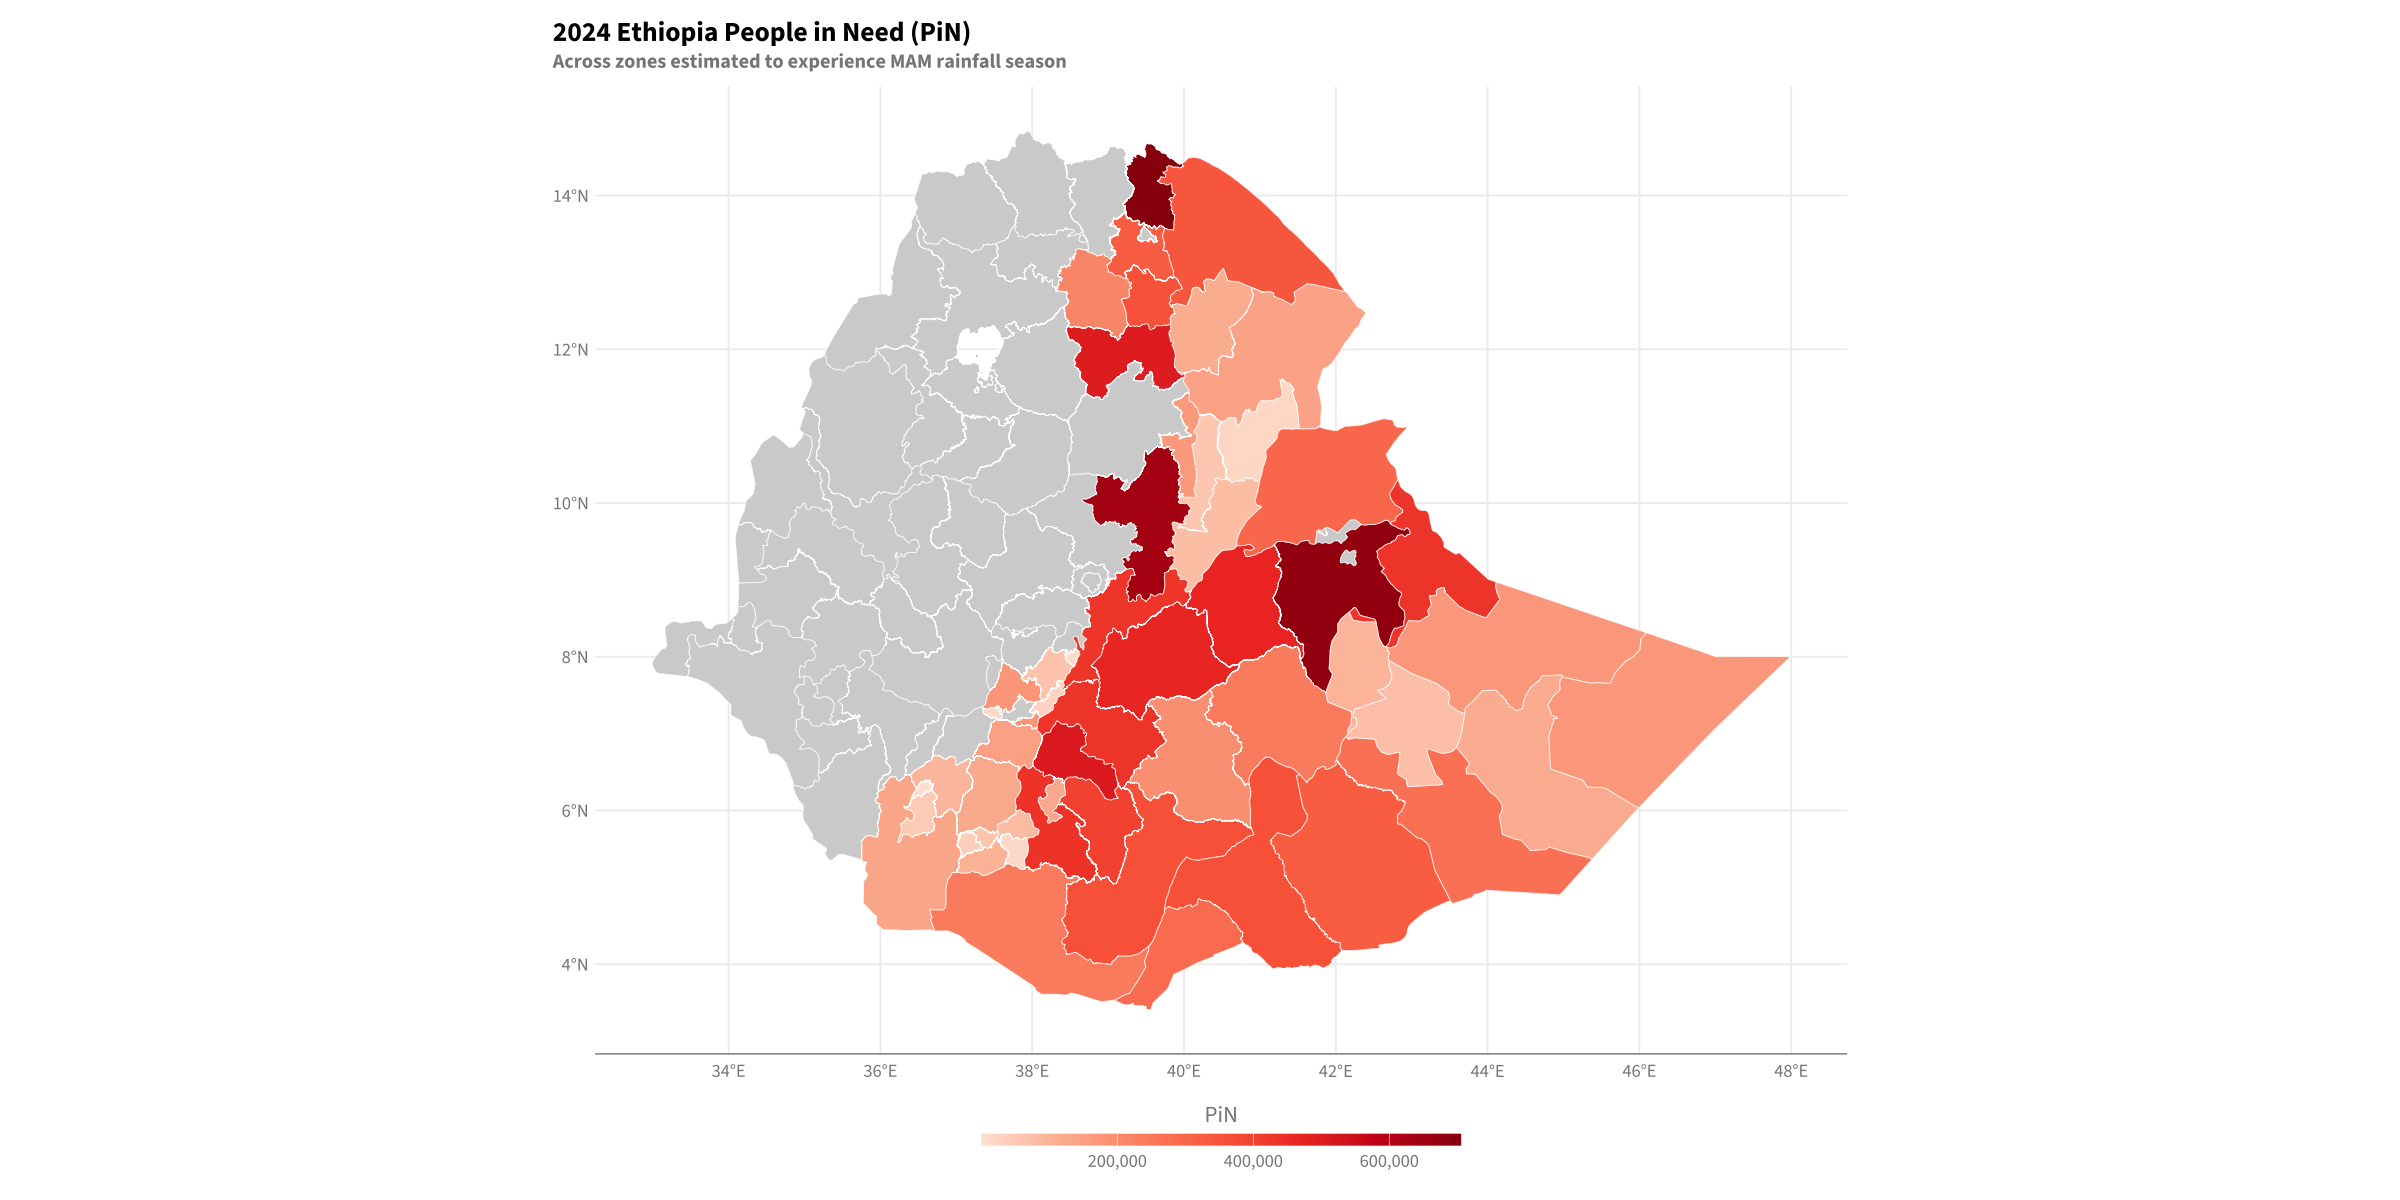

In [9]:
ggplot() +
    geom_sf(data = gdf_adm2, fill = "lightgrey", color = "white") +
    geom_sf(data = gdf_ond_mam, aes(fill = TotalPin), color = "white") +
    scale_fill_distiller(palette = "Reds", direction = 1, labels = label_comma()) + 
    labs(title = "2024 Ethiopia People in Need (PiN)",
       subtitle = "Across zones estimated to experience MAM rainfall season",
       fill = "PiN") + 
    # font_sizing +  
    guides(fill = guide_colorbar(title.position = "top", 
       title.hjust = 0.5,
       barwidth = 20,
       barheight = 0.5)
    )

# ggsave("pin_targetted_zones.png", width = 10, height = 10)

## 2. Getting population data

We can get the population data from HAPI endpoints. Note: The adm2 bounds here are not updated with 2024 data so we have some mismatches.

In [10]:
url <- paste0(
    "https://hapi.humdata.org/api/v1/population-social/population?location_code=ETH&admin_level=2&output_format=json&app_identifier=",
    "ZHMtZXRoOmhhbm5haC5rZXJAdW4ub3Jn",
    "&limit=10000&offset=0")

response <- GET(url)

if (status_code(response) == 200) {
  json_data <- content(response, "text", encoding = "UTF-8")
  data <- jsonlite::fromJSON(json_data)
  df <- as.data.frame(data$data)
} else {
  print(paste("Error: ", status_code(response)))
}

In [11]:
df_pop <- df %>%
    group_by(admin2_code) %>% 
    summarise(
        TotalPop = sum(population, na.rm=TRUE),
    ) %>%
    ungroup()

gdf_ond_mam <- gdf_ond_mam %>%
    merge(df_pop, by.x="admin2Pcode", by.y="admin2_code", all.x=TRUE)

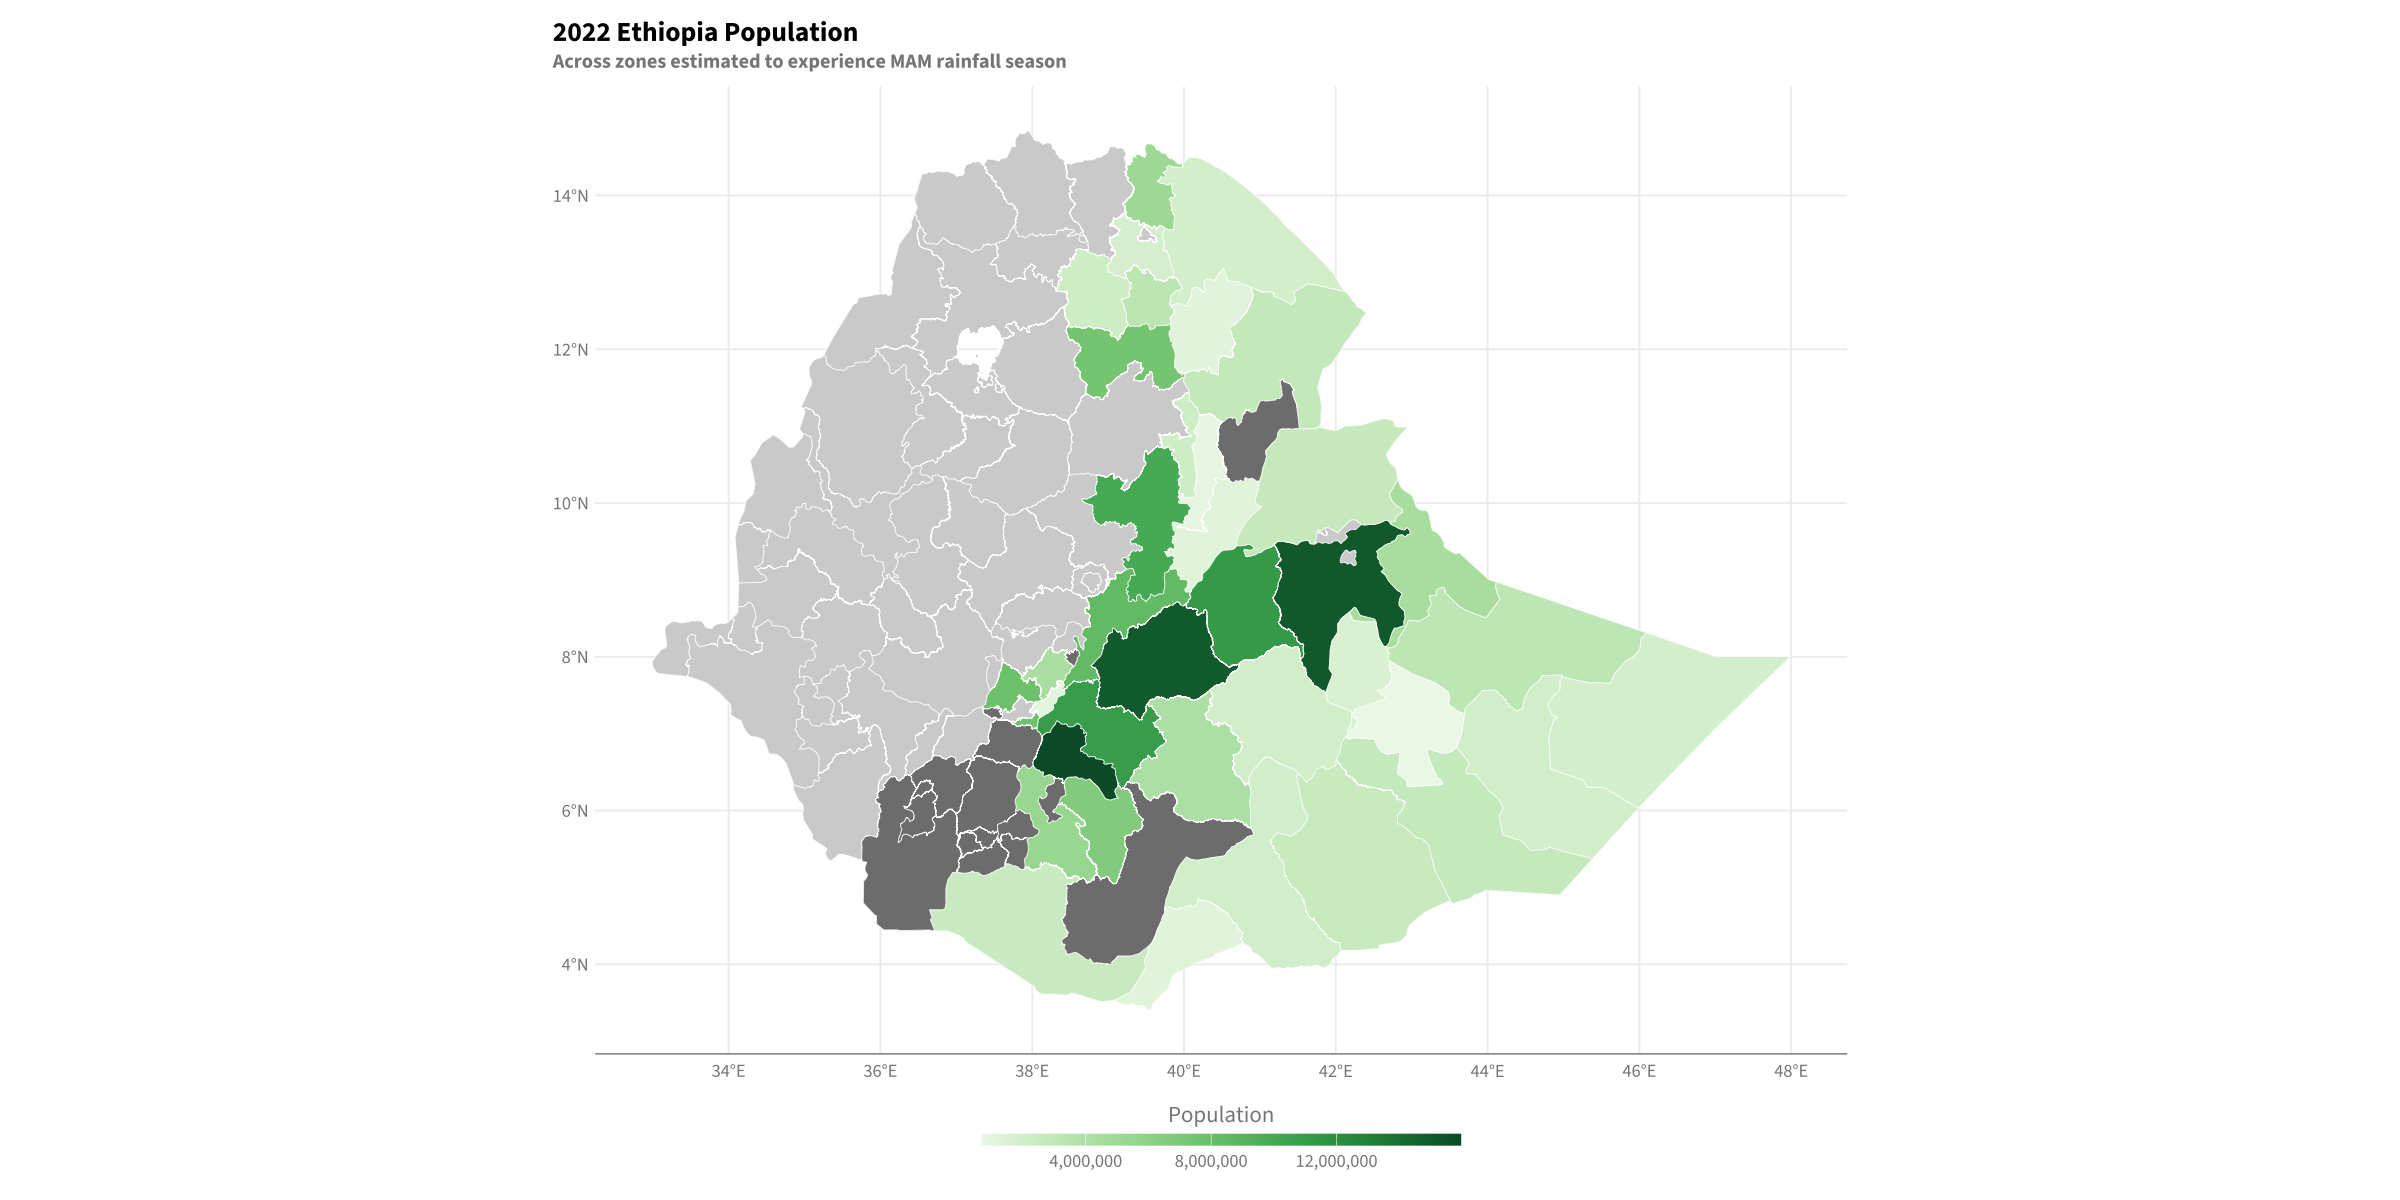

In [12]:
ggplot() +
    geom_sf(data = gdf_adm2, fill = "lightgrey", color = "white") +
    geom_sf(data = gdf_ond_mam, aes(fill = TotalPop), color = "white") +
    scale_fill_distiller(palette = "Greens", direction = 1, labels = label_comma()) + 
    labs(title = "2022 Ethiopia Population",
       subtitle = "Across zones estimated to experience MAM rainfall season",
       fill = "Population") + 
    #font_sizing +  
    guides(fill = guide_colorbar(title.position = "top", 
       title.hjust = 0.5,
       barwidth = 20,
       barheight = 0.5)
    )

#ggsave("pop_targetted_zones.png", width = 10, height = 10)

## 3. Processing rainfall data

We can get Ethiopia's raster stats from the team's PostgreSQL database, where stats are pulled from the ECMWF ERA5 Reanalysis. For each zone, we'll identify years with below average rainfall (identified by the lower tercile or lower quartile). We're focusing specifically on rainfall in the MAM (March, April, May) season, and only on zones within that season.

In [36]:
# Get the historical rainfall data from the database to selected zones
query_era5 <- "SELECT * from public.era5_temp WHERE iso3='ETH' AND adm_level=2"
df_era5 <- dbGetQuery(con, query_era5) %>%
    filter(
        pcode %in% df_mam_ond$admin2Pcode |
        pcode %in% ond_zones
    )

Now we'll:
- Filter by zones only in March/April/May
- Calculate the total average rainfall for the season across each zones, for each year
- Identify years that are in the lower tercile 

In [37]:
df_precip_summary <- df_era5 %>% 
    mutate(year = year(valid_date), month = month(valid_date)) %>%
    # Specifically for ERA5 as values are monthly estimates for total daily precip
    mutate(mean = mean * 30) %>%
    filter(month %in% c(3, 4, 5)) %>%
    group_by(pcode, year) %>% 
    summarise(total_rainfall_mam = sum(mean, na.rm=TRUE)) %>%
    ungroup() %>%
    arrange(pcode, year) %>%
    mutate(year = as.numeric(year)) %>%
    group_by(pcode) %>%
    mutate(
        tercile = ntile(total_rainfall_mam, 3),
        quartile = ntile(total_rainfall_mam, 4),
        is_lower_tercile = tercile == 1,
        is_lower_quartile = quartile == 1
        ) %>%
    ungroup()

`summarise()` has grouped output by 'pcode'. You can
override using the `.groups` argument.


In [40]:
df_thresholds <- df_precip_summary %>%
    group_by(pcode) %>%
    summarise(
        lower_tercile = quantile(total_rainfall_mam, probs = 1/3, na.rm = TRUE),
        lower_quartile = quantile(total_rainfall_mam, probs = 0.25, na.rm = TRUE),
    )

In [39]:
pcodes <- c("ET0103", "ET0201", "ET0511", "ET0702", "ET0104", "ET0202")

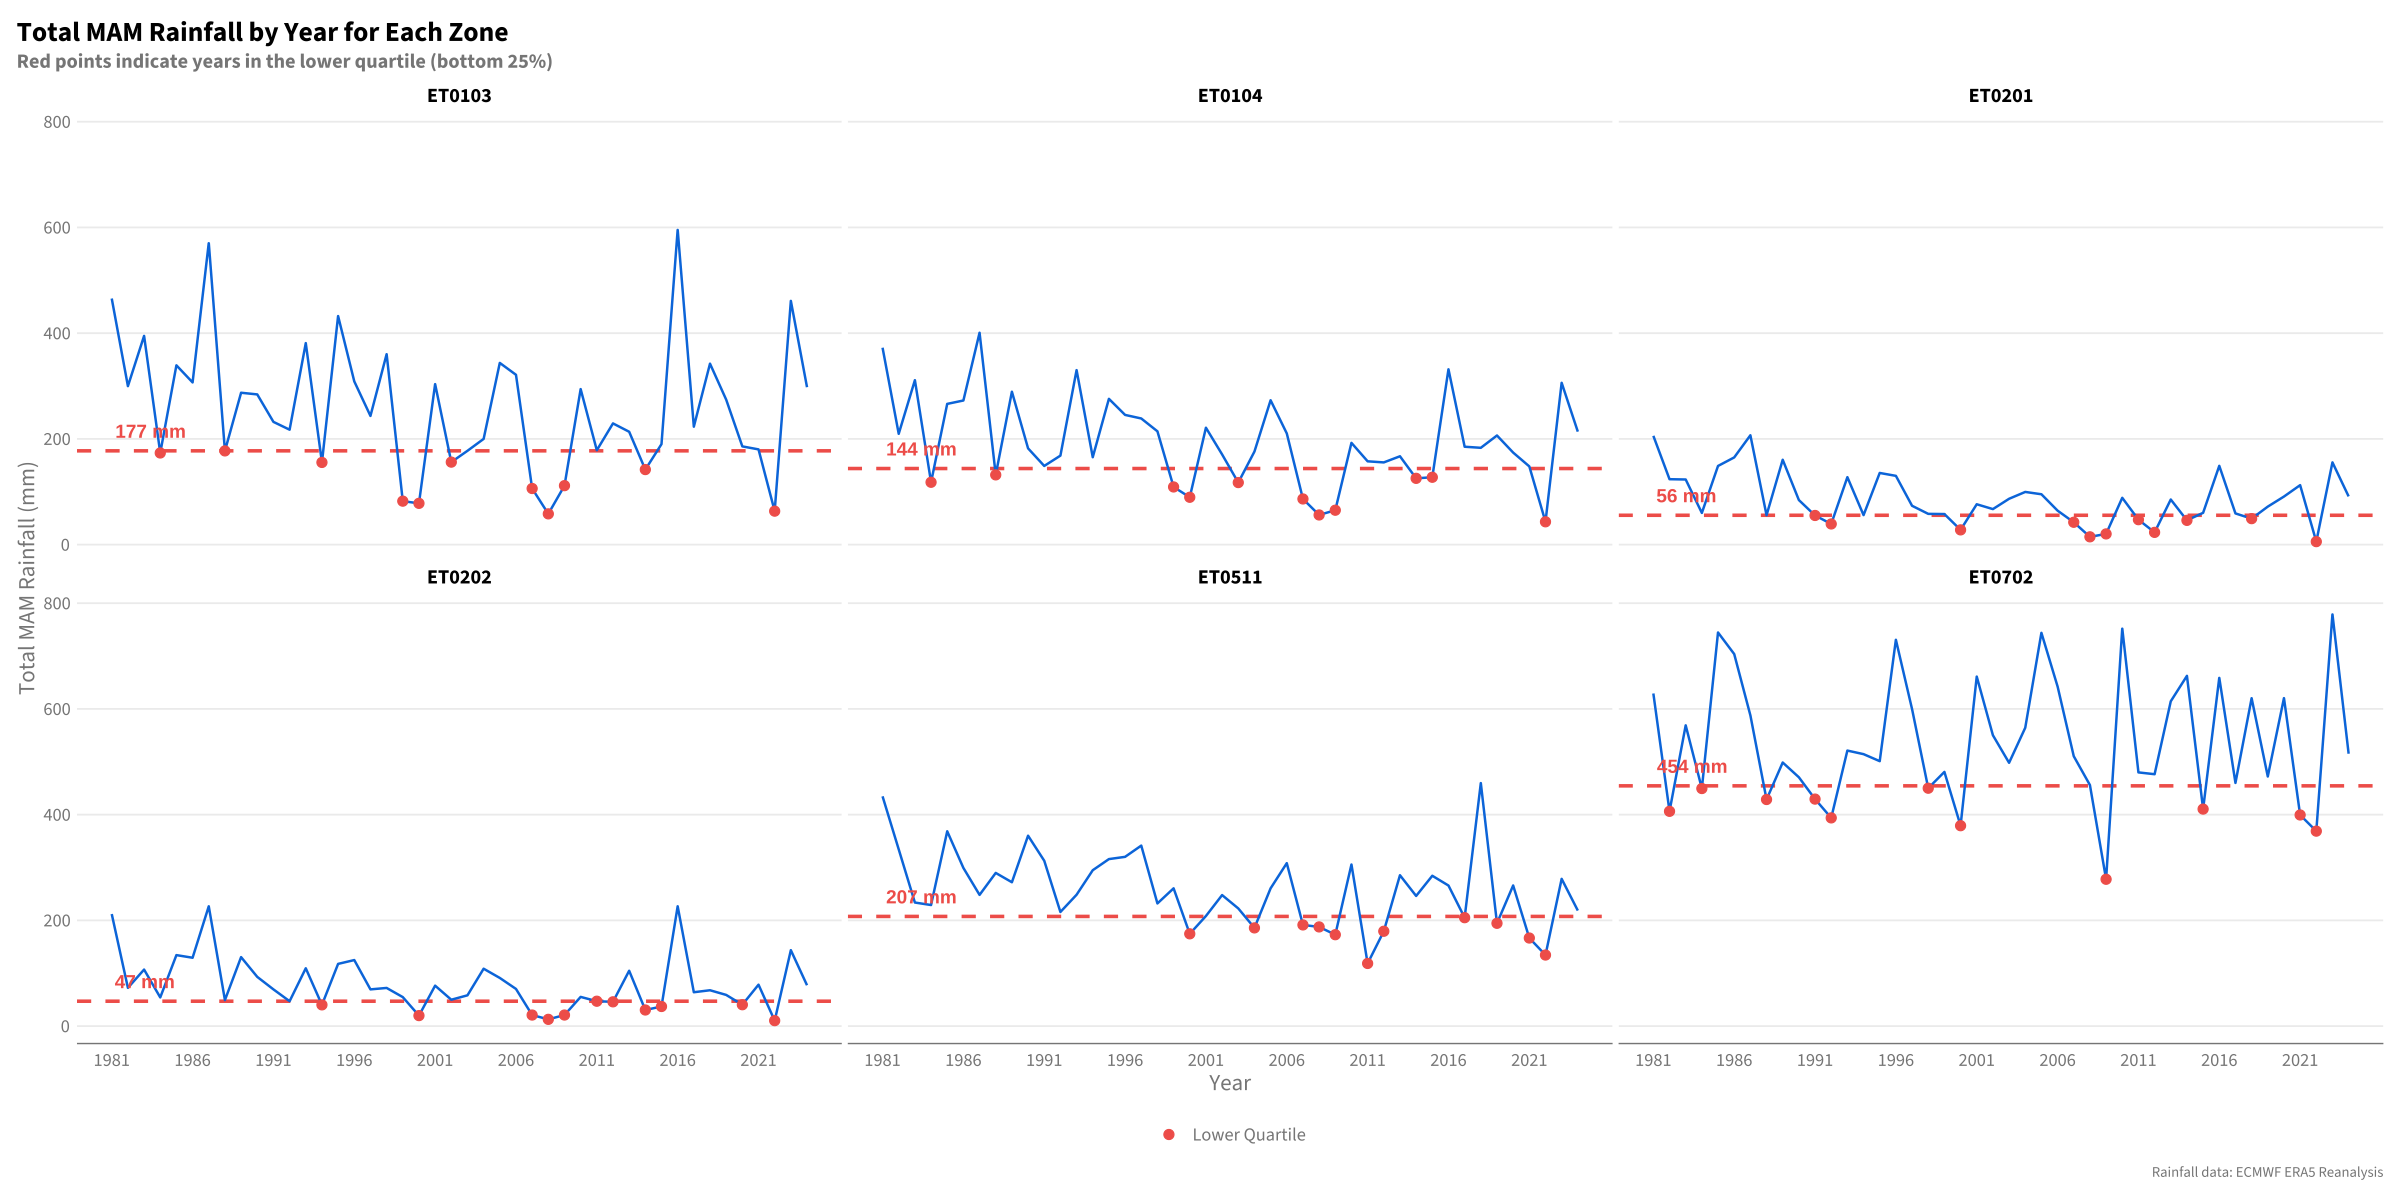

In [41]:
df_precip_sel <- df_precip_summary %>%
    filter(pcode %in% pcodes)
df_thresholds_sel <- df_thresholds %>%
    filter(pcode %in% pcodes)

ggplot(df_precip_sel, aes(x = year, y = total_rainfall_mam, group = pcode)) +
  
  geom_hline(data = df_thresholds_sel, 
             aes(yintercept = lower_quartile),
             color = hdx_hex("tomato-hdx"), linetype = "dashed", size = 1) +

  geom_line(color = hdx_hex("sapphire-hdx"), size = 0.7) +

    geom_text(data = df_thresholds_sel,
                aes(x = min(df_precip_sel$year), 
                    y = lower_quartile, 
                    label = sprintf("%.0f mm", lower_quartile)),
                hjust = -0.05, vjust = -1, size = 4, color = hdx_hex("tomato-hdx"), fontface="bold") +

  geom_point(data = filter(df_precip_sel, is_lower_quartile), 
             aes(color = "Lower Quartile"), size = 2.5) +
  scale_color_manual(values = c("Lower Quartile" = hdx_hex("tomato-hdx"))) +
  facet_wrap(~ pcode, scales = "fixed", ncol = 3) +
  #font_sizing +
  labs(
    title = "Total MAM Rainfall by Year for Each Zone",
    subtitle = "Red points indicate years in the lower quartile (bottom 25%)",
    x = "Year",
    y = "Total MAM Rainfall (mm)",
    caption = "Rainfall data: ECMWF ERA5 Reanalysis",
    color = NULL
  ) +
  scale_x_continuous(breaks = seq(min(df_precip_sel$year), max(df_precip_sel$year), by = 5))

#ggsave("total_rainfall_by_zone_quartile_sel.png", width = 15, height = 10)

## 3. Joining rainfall data with PiN and population

Only keep the PiN/pop values for years that are in the lower tercile/quartile, and then sum the total PiN/pop for each year.

In [42]:
gdf_pin <- gdf_ond_mam %>%
    select("admin2Pcode", "admin2Name_en", "TotalPin", "geometry")

In [43]:
df_precip_summary_merged <- df_precip_summary %>%
    left_join(gdf_ond_mam, by = c("pcode" = "admin2Pcode")) %>%
    mutate(TotalPin_tercile = if_else(is_lower_tercile == FALSE, 0, TotalPin)) %>%
    mutate(TotalPopulation_tercile = if_else(is_lower_tercile == FALSE, 0, TotalPop)) %>%
    mutate(TotalPin_quartile = if_else(is_lower_quartile == FALSE, 0, TotalPin)) %>%
    mutate(TotalPopulation_quartile = if_else(is_lower_quartile == FALSE, 0, TotalPop)) 

## 4. Calculating annual impact 

In [44]:
severity <- "quartile"
metric <- "Pin"

In [45]:
calc_yearly_impact <- function(df, severity, metric) {
    col <- paste0("Total", metric, "_", severity)
    df_ <- df %>% 
    group_by(year) %>% 
    summarise(
        total_affected = sum(!!sym(col), na.rm=TRUE),
        affected_zones = paste(pcode[!!sym(col) != 0], collapse = ", "),
        total_unique_pcodes = n_distinct(pcode),
        affected_unique_pcodes = n_distinct(pcode[!!sym(col) != 0]),
        proportion_zones_affected = affected_unique_pcodes / total_unique_pcodes
    ) %>%
    ungroup() %>%
    arrange(year)

    return(df_)
}

In [46]:
df_affected <- calc_yearly_impact(df_precip_summary_merged, severity, metric)

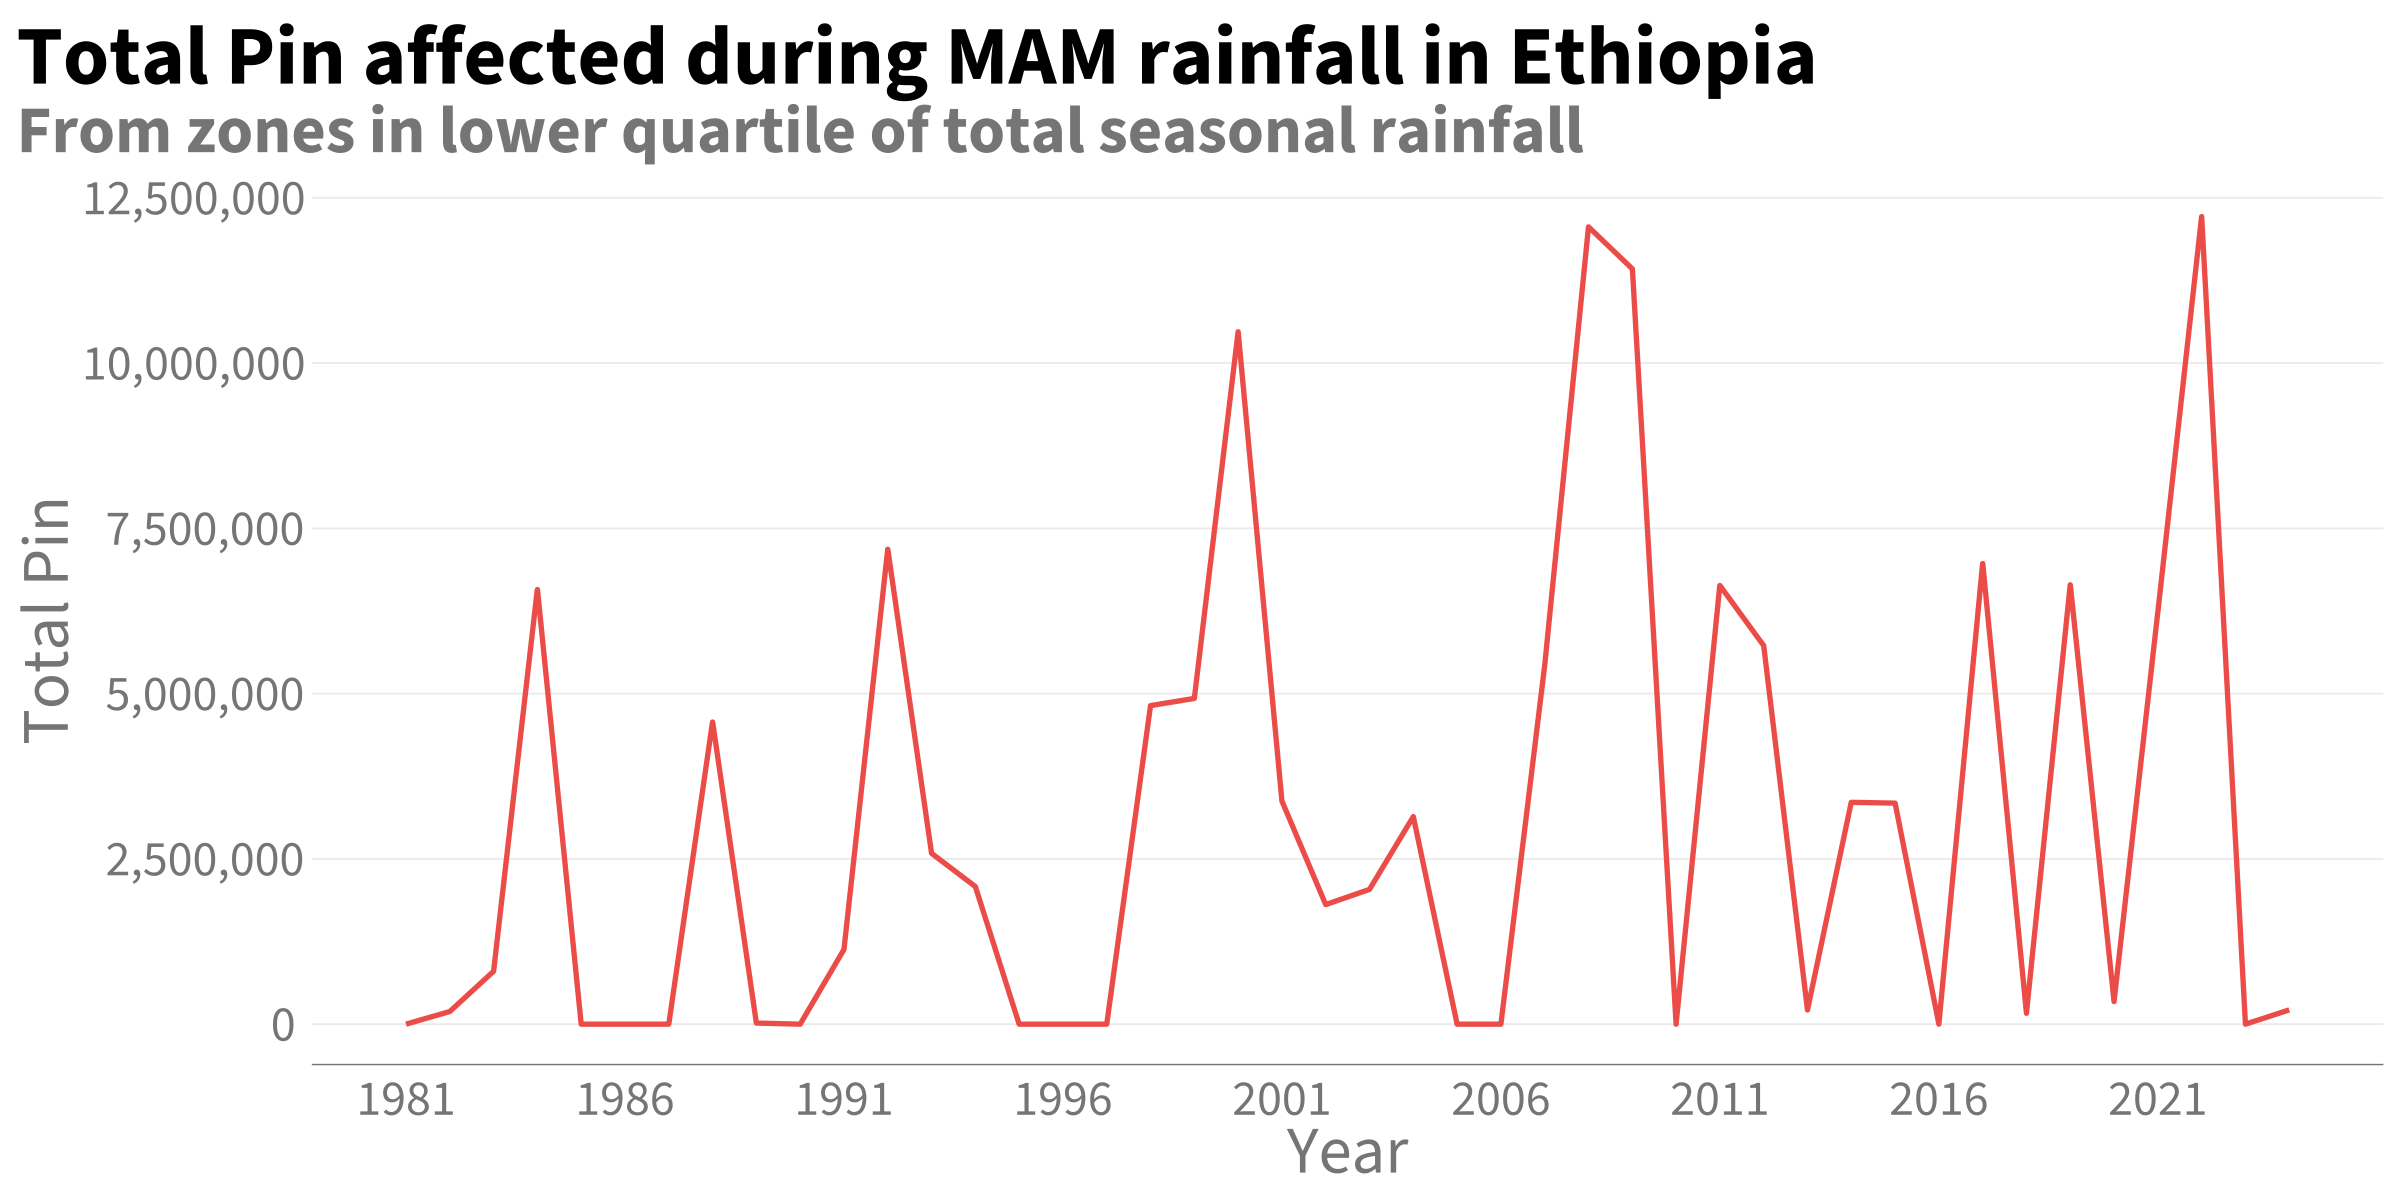

In [48]:
ggplot(df_affected, aes(x=year, y=total_affected)) + 
    geom_line(color = hdx_hex("tomato-hdx"), size = 1.5) +
    # TODO: This is pretty manual...
    # geom_point(x=2012, y=8990095.8, size=5, color="#F2645A") +
    scale_x_continuous(breaks = seq(min(df_affected$year), max(df_affected$year), by = 5)) +
    scale_y_continuous(labels = comma_format(big.mark = ",")) +
    font_sizing + 
  labs(
    title = paste0("Total ",  metric, " affected during MAM rainfall in Ethiopia"),
    subtitle = paste0("From zones in lower ", severity, " of total seasonal rainfall"),
    x = "Year",
    y = paste0("Total ", metric),
  ) 

ggsave("total_pin_affected.png", width = 30, height = 10, units = "cm")

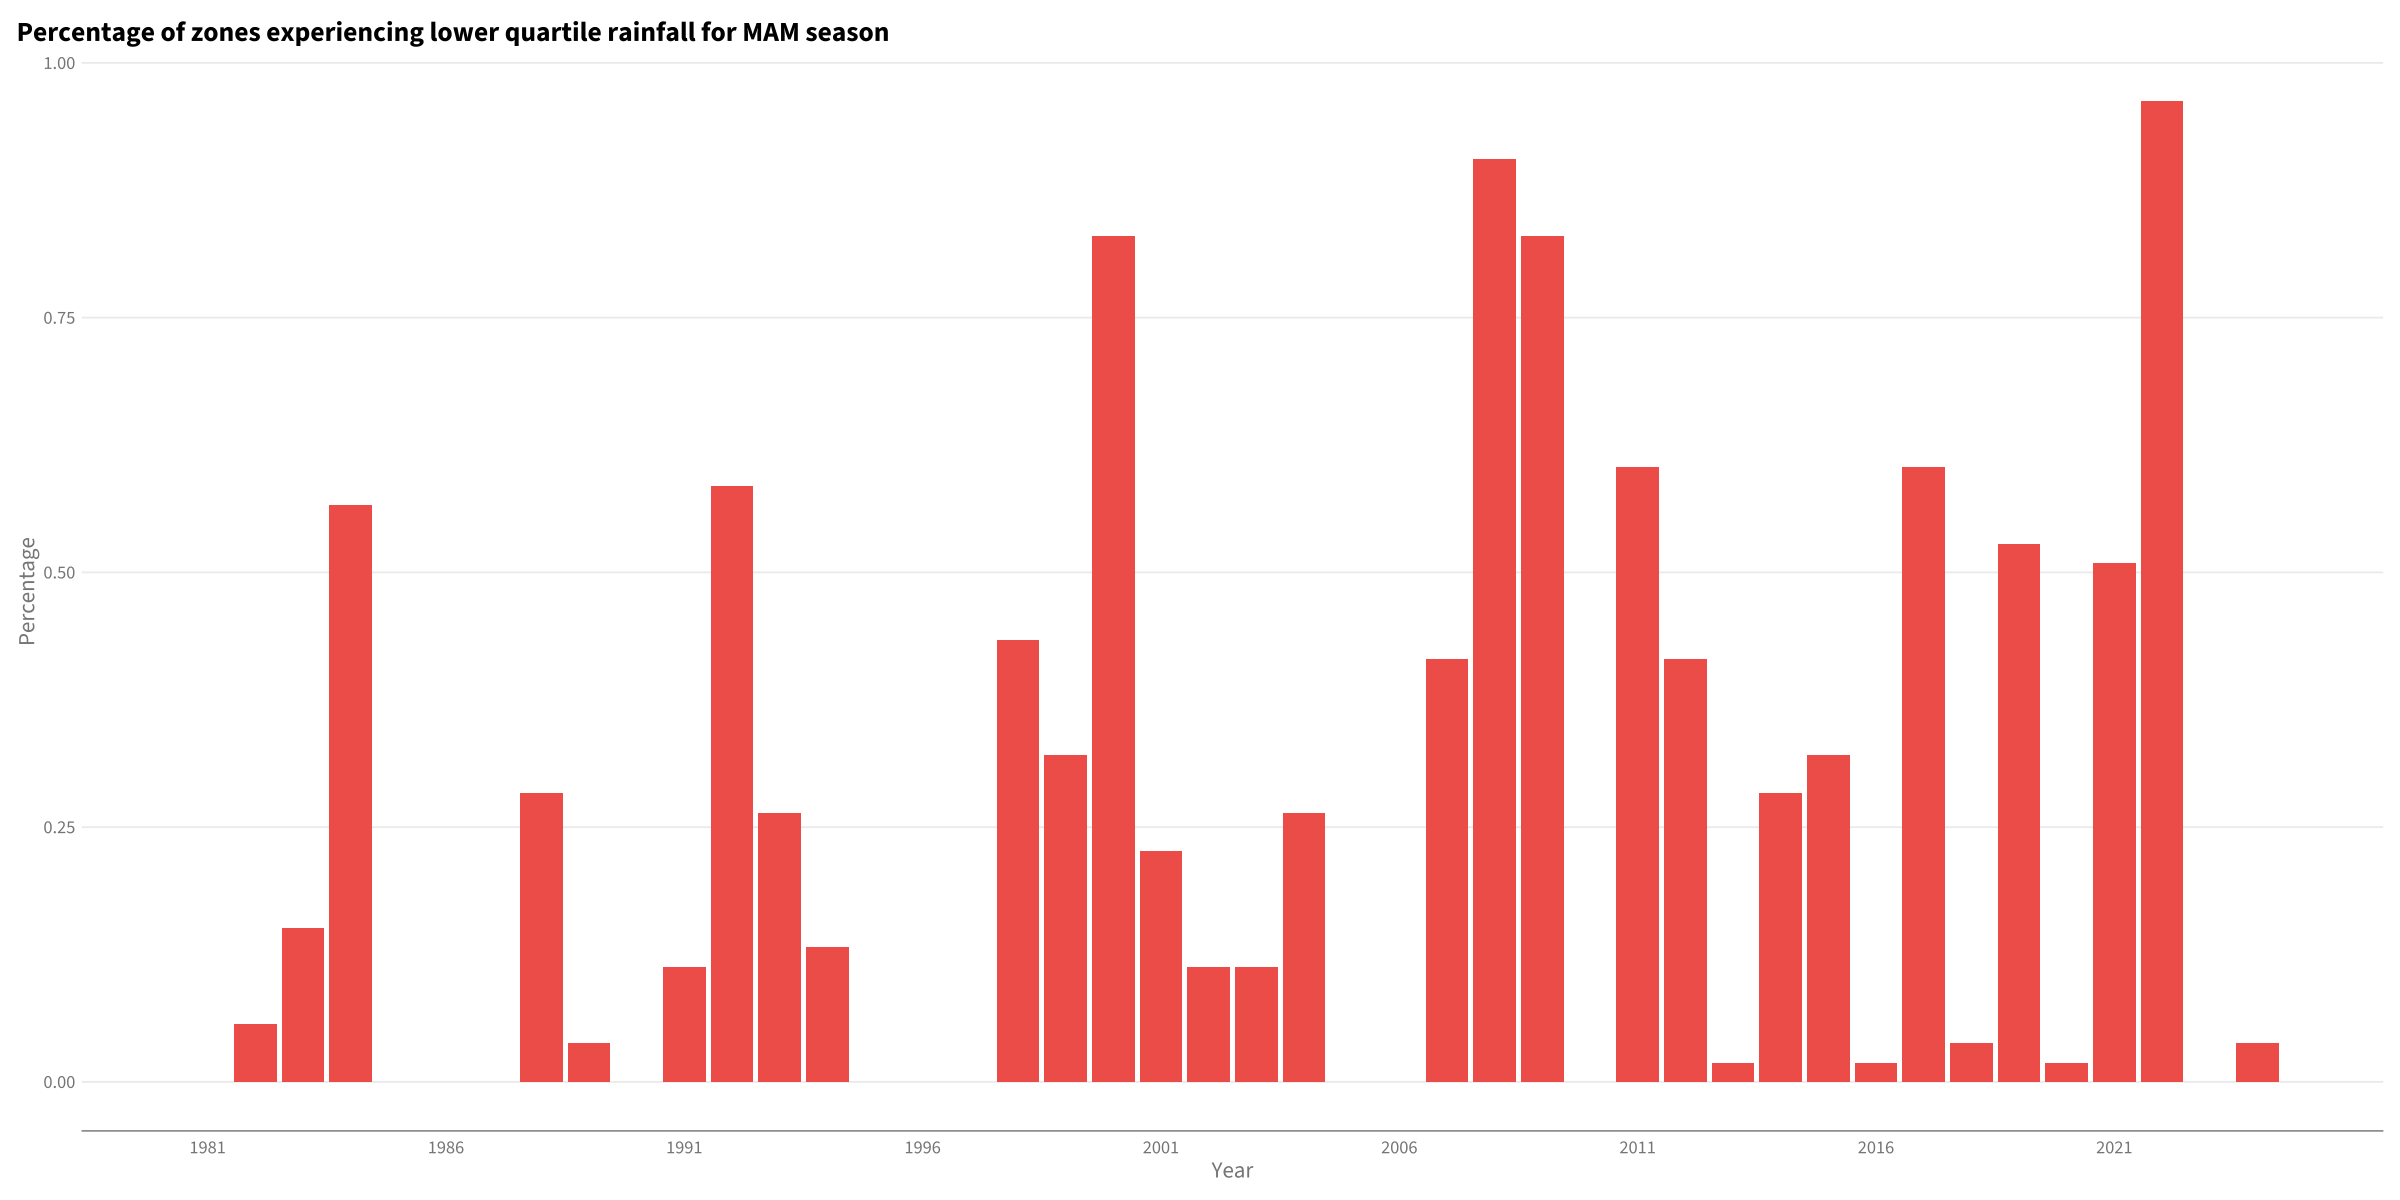

In [50]:
ggplot(df_affected, aes(x=year)) + 
    geom_bar(aes(y=proportion_zones_affected), fill = hdx_hex("tomato-hdx"), stat = "identity") + 
    scale_x_continuous(breaks = seq(min(df_affected$year), max(df_affected$year), by = 5)) +
    scale_y_continuous(labels = comma_format(big.mark = ",")) +
    #font_sizing + 
    labs(
        title = paste0("Percentage of zones experiencing lower ", severity, " rainfall for MAM season"),
        x = "Year",
        y = "Percentage",
    ) 

# ggsave("prop_pin_quartile.png", width = 30, height = 10, units = "cm")

## 4. Identifying the worst years

Now rank all years and create a map of all zones

In [51]:
df_affected  %>% arrange(desc(total_affected)) %>% select(year, total_affected) %>% head(5)

year,total_affected
<dbl>,<dbl>
2022,12215846
2008,12060300
2009,11426484
2000,10473750
1992,7183786


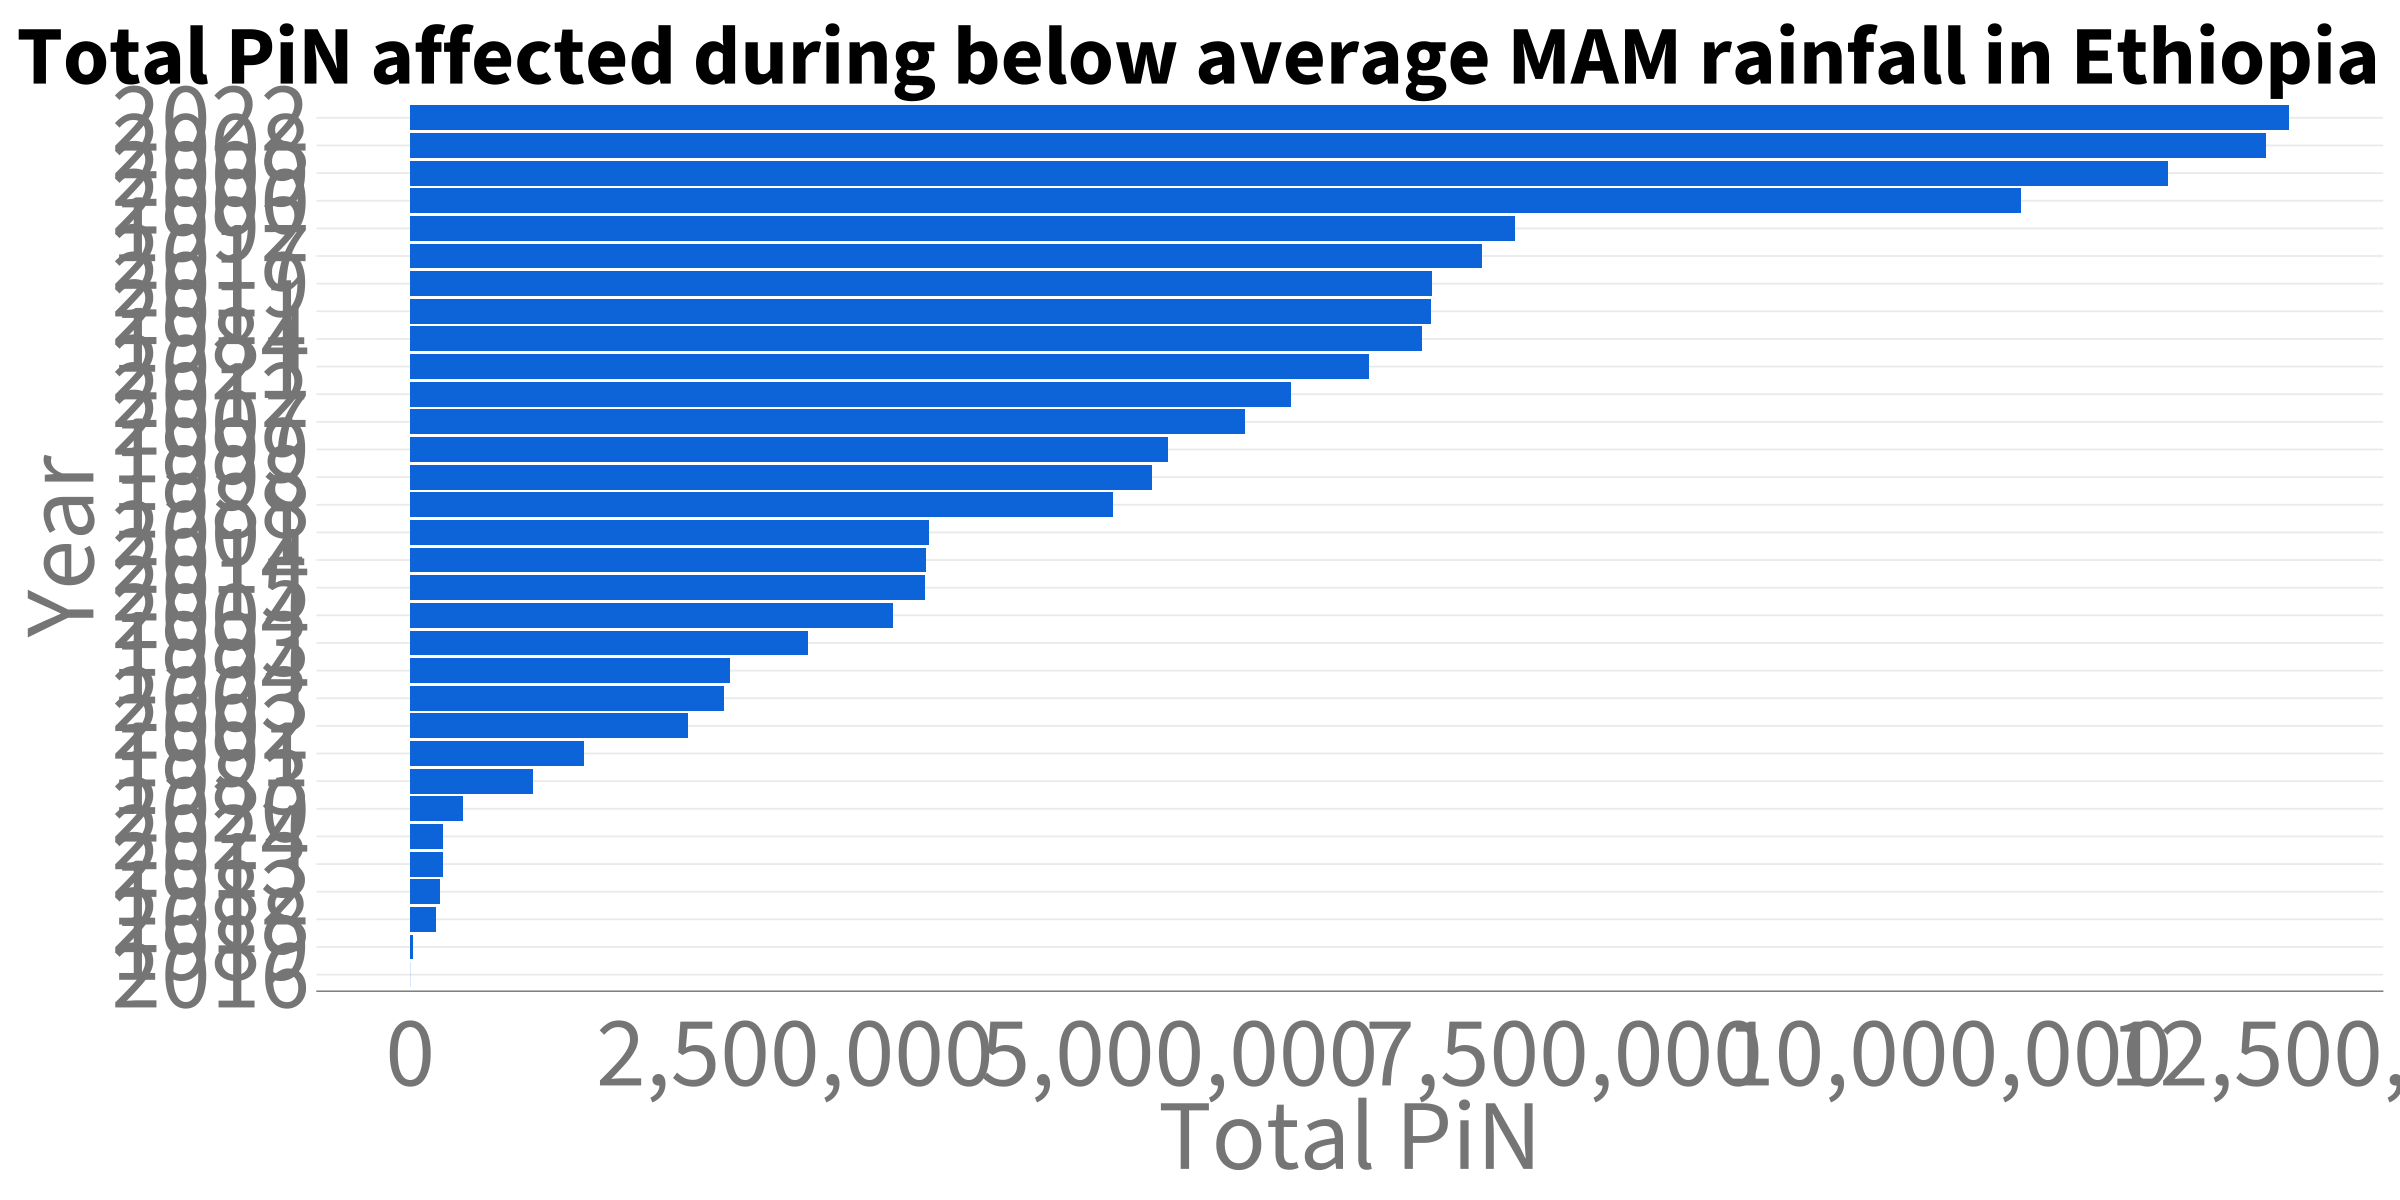

In [120]:
df_affected_summary <- df_affected %>% arrange(total_affected) %>% filter(total_affected != 0)
df_affected_summary$year <- factor(df_affected_summary$year, levels = df_affected_summary$year)

ggplot(df_affected_summary, aes(x=year, y=total_affected)) + 
    geom_bar(fill = hdx_hex("sapphire-hdx"), stat="identity") +
    scale_y_continuous(labels = comma_format(big.mark = ",")) +
    labs(x="Year", y="Total PiN", title="Total PiN affected during below average MAM rainfall in Ethiopia") +
    coord_flip() + 
    font_sizing

ggsave("total_affected_bar.png", width = 20, height = 30, units = "cm")

In [57]:
create_yearly_map <- function(df_yearly_pin, gdf_ond_mam, gdf_adm2, selected_year) {
    df_yearly_pin <- df_yearly_pin %>% 
        filter(year == selected_year)
    
    affected_zones <- str_split(df_yearly_pin$affected_zones, ", ")[[1]]

    sf_all_zones <- gdf_adm2 %>%
        mutate(status = case_when(
          admin2Pcode %in% affected_zones ~ "Zones in lower quartile of seasonal rainfall",
          admin2Pcode %in% gdf_ond_mam$admin2Pcode ~ "Potential zones in season",
          TRUE ~ "Other zones"
        ))
      
      ggplot() +
        geom_sf(data = sf_all_zones, aes(fill = status), color = "black") +
        font_sizing + 
        theme(legend.text = element_text(size = 50)) + 

        labs(title = paste("Affected Zones in", selected_year),
        #subtitle = paste("Total PIN:", year_data$total_pin),
        fill = "Zone Status") +
        scale_fill_manual(
          values = c("white", "grey", hdx_hex("tomato-hdx")),
          labels = c("Other zones", "Potential zones in season", "Zones in lower quartile of seasonal rainfall"),
          name = "Zone Status"
        )
    ggsave(paste0("targeted_", selected_year, ".png"), width = 30, height = 30, units = "cm")
}

In [62]:
create_yearly_map(df_affected, gdf_ond_mam, gdf_adm2, 2000)

## Misc other plots

In [145]:
# df_pop_mam <- gdf_merged %>% 
#     group_by(year) %>% 
#     summarise(
#         total_pop = sum(TotalPop, na.rm=TRUE),
#         total_pin = sum(TotalPin, na.rm=TRUE),
#         affected_zones = paste(pcode[TotalPin != 0], collapse = ", "),
#         total_unique_pcodes = n_distinct(pcode),
#         affected_unique_pcodes = n_distinct(pcode[TotalPin != 0]),
#         proportion_zones_affected = affected_unique_pcodes / total_unique_pcodes
#     ) %>%
#     ungroup() %>%
#     arrange(year)

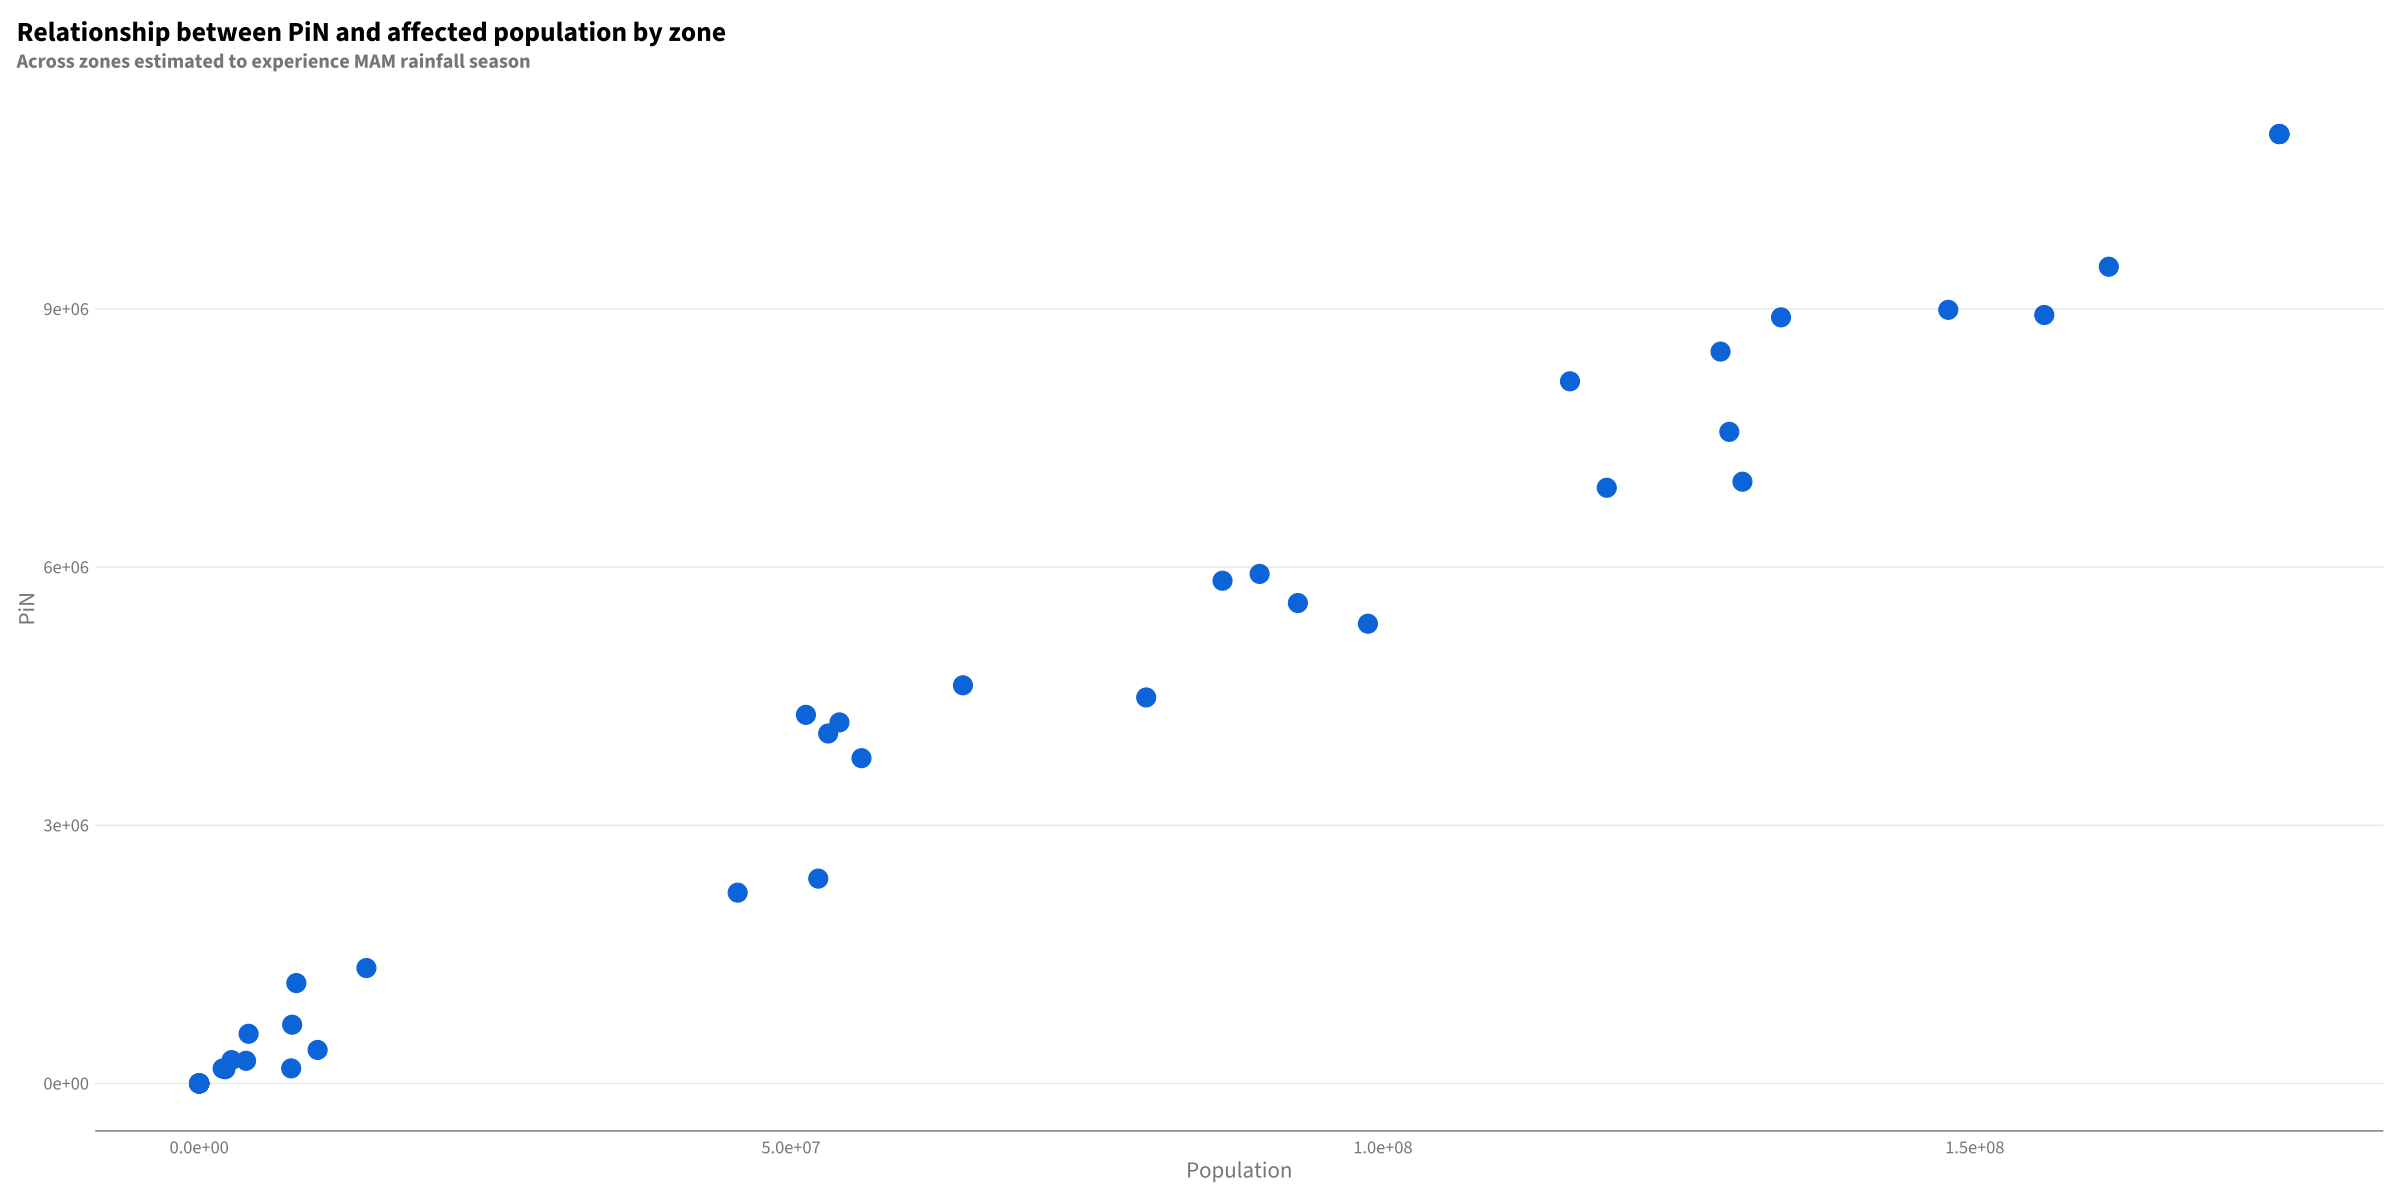

In [285]:
# ggplot(df_pop_mam, aes(x=total_pop, y=total_pin)) + 
#     geom_point(size=5) +
#     # font_sizing +  
#     labs(
#         title = "Relationship between PiN and affected population by zone",
#         subtitle = "Across zones estimated to experience MAM rainfall season",
#         x = "Population",
#         y = "PiN",
#     ) 
# # ggsave("pop_vs_pin.png", width = 15, height = 10)